In [1]:
import sys
sys.executable

'/data/xchem-fragalysis/mferla/neoconda/bin/python'

In [10]:
from fragmenstein_merge_sw_place import DEFAULT_WEIGHTS, search, place, score

In [3]:
from rdkit import Chem
from pathlib import Path

with Chem.SDMolSupplier('zika_hits_ranked_filtered.sdf') as sdfh:
    mols = list(sdfh)

pdbblock = Path('../template.pdb').read_text()

In [63]:
from rdkit.Chem import PandasTools

silvren = PandasTools.LoadSDF('zika_hits_ranked_filtered.sdf', idName='name', smilesName='simple_smiles', molColName='minimized_mol')

silvren['unminimized_mol'] = silvren['minimized_mol']
silvren['hit_mols'] = silvren['minimized_mol'].apply(lambda h: [h])
silvren['hit_names'] = silvren['minimized_mol'].apply(lambda h: [h.GetProp('_Name')])

In [ ]:
sw_db = 'REAL-Database-22Q1.smi.anon'
s = search(silvren, sw_db=sw_db, suffix='_janke', sw_dist=20, sw_length=50, top_mergers=100_000, ranking='∆∆G')

In [ ]:
import pandas as pd
similars: pd.DataFrame = s.drop_duplicates('smiles')
similars.to_pickle(f'similars_janke.pkl.gz')
placements: pd.DataFrame = place(similars, pdbblock, n_cores=100, timeout=600, suffix='_Janke')

In [13]:
score(placements, silvren,
      hits=silvren.minimized_mol.to_list(),
      suffix='_janke',
      weights=DEFAULT_WEIGHTS)

In [51]:
placements.to_pickle(f'placements_janke.pkl.gz')

## Upload

In [55]:
method_name = 'Silvr-original'
top_N = 200
target_name='XX01ZVNS2B'
ref_url='https://arxiv.org/abs/2304.10905'
submitter_name='Janke Scheen'
submitter_email='jenke.scheen@choderalab.org'

from collections import defaultdict
from typing import List
from gist_import import GistImporter

fmodule = GistImporter.from_github('https://raw.githubusercontent.com/matteoferla/Fragment-hit-follow-up-chemistry/main/followup/prep_fragalysis.py')
prep = fmodule['prep']
generate_header = fmodule['generate_header']

def fix(mol: Chem.Mol):
    assert isinstance(mol, Chem.Mol)
    assert mol.GetNumAtoms()
    mol.ClearComputedProps()
    for name in mol.GetPropNames():
        mol.ClearProp(name)

tally = defaultdict(int)
def assign_rank(row):
    k = ','.join(row.hit_names)
    tally[k] += 1
    return tally[k]

def fix_name(val):
    return  '_'.join(val.split('-')[-4:-2]) + \
            ',' + \
            '_'.join(val.split('-')[-2:])

def extract_vendor(val):
    return '-'.join(val.split('-')[:-8])

silvren ['merger_rank'] = silvren .sort_values('ad_hoc_penalty').apply(assign_rank, axis=1)
silvren ['merger_rank'] = silvren ['merger_rank'].fillna(999).astype(int)

with pd.option_context('mode.chained_assignment', None):

    df = silvren .loc[silvren .outcome == 'acceptable']\
                   .sort_values('ad_hoc_penalty')\
                   .rename(columns={c: ':'.join(map(str, c)) for c in placements.columns if isinstance(c, tuple)})\
                   .reset_index()
    df = df.loc[df.merger_rank < 5].head(int(top_N)).copy()
    # list of str to str w/ comma-separator
    df['ref_mols'] = df.hit_names.apply(lambda l: ','.join([v.replace(f'{target_name}-', '') for v in l])).apply(fix_name)
    df['washed_mol'] = df.minimized_mol.apply(fix)
    df['name'] = df['name'].apply(lambda v: v.split('-'+target_name)[0]).apply(extract_vendor)
    # non str/float/ints
    not_okay = ('name', 'minimized_mol', 'ref_mols', 'washed_mol', 'mode',
                'runtime','error','outcome',
                'smiles','simple_smiles', 'new_name',
                 'regarded', 'disregarded', 'hit_names',
                  '∆G_bound',
                 '∆G_unbound',
                 'unmin_binary',
                 'min_binary',
                'binary_hits', 'custom_map', 'PAINSes',
                 'hit_binaries',
                'minimized_mol',
                  'hit_mols','unminimized_mol', 'hit_names')
nonempty = [c for c, v in (df[[c for c in df.columns if ':' in c]].sum() > 0).to_dict().items() if v]
extras: List[str] = [c for c in df.columns if c not in not_okay and ':' not in c] + nonempty
def floatify(value):
    try:
        return float(value)
    except Exception:
        return float('nan')

bad_columns = [k for k in extras if df[k].apply(floatify).isna().any()]
assert not bad_columns, f'Some entries are not numeric {bad_columns}'
header: Chem.Mol = generate_header(method_name,
                         ref_url=ref_url,
                         submitter_name=submitter_name,
                         submitter_email=submitter_email,
                         extras=dict(zip(extras, extras))
                        )
prep(df, header, mol_col='minimized_mol', name_col='name', outfile=f'{method_name}.sdf', ref_pdb='x0051_0B',
     extras=extras
    )
print(f'{method_name}.sdf', len(df))

Silvr-original.sdf 129


In [52]:
method_name = 'Silvr-catalog'
top_N = 200
target_name='XX01ZVNS2B'
ref_url='https://arxiv.org/abs/2304.10905'
submitter_name='Janke Scheen'
submitter_email='jenke.scheen@choderalab.org'

from collections import defaultdict
from typing import List
from gist_import import GistImporter

fmodule = GistImporter.from_github('https://raw.githubusercontent.com/matteoferla/Fragment-hit-follow-up-chemistry/main/followup/prep_fragalysis.py')
prep = fmodule['prep']
generate_header = fmodule['generate_header']

def fix(mol: Chem.Mol):
    assert isinstance(mol, Chem.Mol)
    assert mol.GetNumAtoms()
    mol.ClearComputedProps()
    for name in mol.GetPropNames():
        mol.ClearProp(name)

tally = defaultdict(int)
def assign_rank(row):
    k = ','.join(row.hit_names)
    tally[k] += 1
    return tally[k]

def fix_name(val):
    return  '_'.join(val.split('-')[-4:-2]) + \
            ',' + \
            '_'.join(val.split('-')[-2:])

def extract_vendor(val):
    return '-'.join(val.split('-')[:-8])

placements['merger_rank'] = placements.sort_values('ad_hoc_penalty').drop_duplicates('cluster').apply(assign_rank, axis=1)
placements['merger_rank'] = placements['merger_rank'].fillna(999).astype(int)

with pd.option_context('mode.chained_assignment', None):

    df = placements.loc[placements.outcome == 'acceptable']\
                   .sort_values('ad_hoc_penalty')\
                   .rename(columns={c: ':'.join(map(str, c)) for c in placements.columns if isinstance(c, tuple)})\
                   .reset_index()
    df = df.loc[df.merger_rank < 5].head(int(top_N)).copy()
    # list of str to str w/ comma-separator
    df['ref_mols'] = df.hit_names.apply(lambda l: ','.join([v.replace(f'{target_name}-', '') for v in l])).apply(fix_name)
    df['washed_mol'] = df.minimized_mol.apply(fix)
    df['name'] = df['name'].apply(lambda v: v.split('-'+target_name)[0]).apply(extract_vendor)
    # non str/float/ints
    not_okay = ('name', 'minimized_mol', 'ref_mols', 'washed_mol', 'mode',
                'runtime','error','outcome',
                'smiles',
                 'regarded', 'disregarded', 'hit_names',
                  '∆G_bound',
                 '∆G_unbound',
                 'unmin_binary',
                 'min_binary',
                'binary_hits', 'custom_map', 'PAINSes',
                 'hit_binaries',
                'minimized_mol',
                  'hit_mols','unminimized_mol', 'hit_names')
nonempty = [c for c, v in (df[[c for c in df.columns if ':' in c]].sum() > 0).to_dict().items() if v]
extras: List[str] = [c for c in df.columns if c not in not_okay and ':' not in c] + nonempty
def floatify(value):
    try:
        return float(value)
    except Exception:
        return float('nan')

bad_columns = [k for k in extras if df[k].apply(floatify).isna().any()]
assert not bad_columns, f'Some entries are not numeric {bad_columns}'
header: Chem.Mol = generate_header(method_name,
                         ref_url=ref_url,
                         submitter_name=submitter_name,
                         submitter_email=submitter_email,
                         extras=dict(zip(extras, extras))
                        )
prep(df, header, mol_col='minimized_mol', name_col='name', outfile=f'{method_name}.sdf', ref_pdb='x0051_0B',
     extras=extras
    )
print(f'{method_name}.sdf', len(df))

Silvr-catalog.sdf 200


## Sanity Check

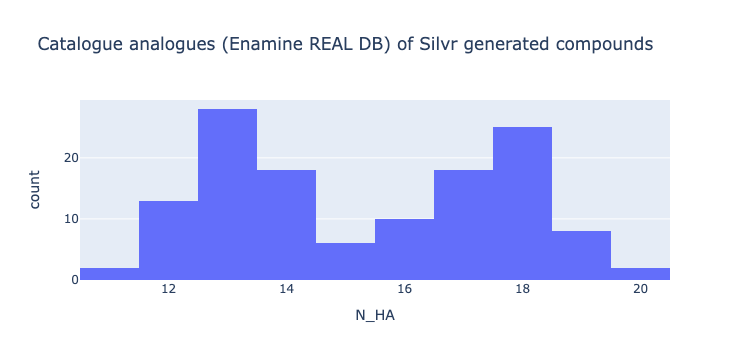

In [78]:
import plotly.express as px
silvren['N_HA'] = silvren.N_HA.astype(float)
px.histogram(silvren.sort_values('N_HA'), 'N_HA',
            title='Catalogue analogues (Enamine REAL DB) of Silvr generated compounds')

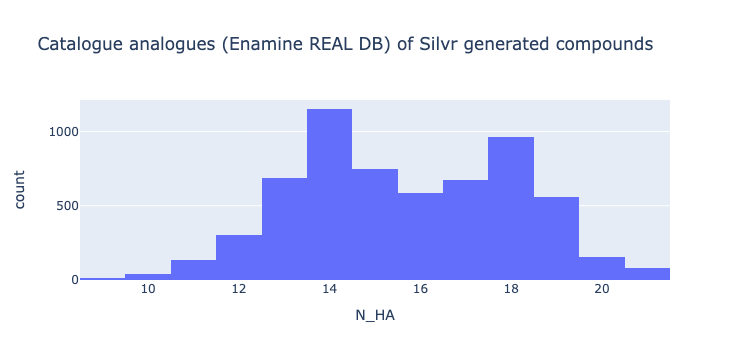

In [79]:
import plotly.express as px

px.histogram(placements.loc[placements.N_HA > 0].sort_values('N_HA'), x='N_HA',
             title='Catalogue analogues (Enamine REAL DB) of Silvr generated compounds'
            )